In [8]:
import numpy as np
import os
import glob
import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
eps = np.finfo(float).eps

import tqdm
from torchsummary import summary

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(3)
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
print(use_cuda)

True


In [10]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kernel_height, kernel_width = self.weight.size()
        self.mask.fill_(0)
        half_h, half_w = kernel_height // 2, kernel_width // 2
    
        self.mask[:, :, :half_h, :] = 1.0
        self.mask[:, :, half_h, :half_w] = 1.0
        if self.mask_type == 'A':
            self.mask[:, :, half_h, half_w] = 0.0
        else:
            self.mask[:, :, half_h, half_w] = 1.0
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

    
class ResidualBlock(nn.Module):
    def __init__(self, h):
        super(ResidualBlock, self).__init__()
        self.h = h
        # todo: set padding to same
        self.network = []
        self.network.extend([
            nn.Conv2d(self.h, self.h // 2, (1, 1)),
            nn.BatchNorm2d(self.h // 2),
            nn.ReLU()
        ])
        self.network.extend([
            MaskedConv2d('B', self.h // 2, self.h // 2, (3, 3), padding=1),
            nn.BatchNorm2d(self.h // 2),
            nn.ReLU()
        ])
        
        self.network.extend([
            nn.Conv2d(self.h // 2, self.h, (1, 1)),
            nn.BatchNorm2d(self.h),
            nn.ReLU()
        ])
        
        self.network = nn.Sequential(*self.network)
        
    def forward(self, x):
        skip = x
        x = self.network(x)
        return F.relu(x + skip)


class PixelCNN(nn.Module):
    def __init__(self, in_channels):
        super(PixelCNN, self).__init__()
        
        self.in_channels = in_channels
        
        self.network = [nn.BatchNorm2d(3)]
        
        # 7x7 Conv input, type A
        self.network.extend([
            MaskedConv2d('A', 3, self.in_channels, (7, 7), padding=3),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU()
        ])

        self.network.extend(
            [ResidualBlock(self.in_channels) for _ in range(12)]
        )
        
#         # 3x3 Conv input, type B
#         self.network.extend([
#             MaskedConv2d('B', self.in_channels, self.in_channels, (3, 3), padding=1),
#             nn.BatchNorm2d(self.in_channels),
#             nn.ReLU(),
#         ])
        
#         # 1x1 Conv input
        self.network.extend([
            nn.Conv2d(self.in_channels, self.in_channels, (1, 1)),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU()])
        self.network.extend([nn.Conv2d(self.in_channels, 12, (1, 1))])
        
        self.network = nn.Sequential(*self.network)

        
    def forward(self, x):
        x = self.network(x)
        x = x.reshape(x.size(0) , 4, 3 , 28, 28)

        return x

In [21]:
model = PixelCNN(128)
model.load_state_dict(torch.load('models/pixelcnn_10epochs_arch2_batch_64.pt'))
model = model.cuda() if use_cuda else model

model.eval()

PixelCNN(
  (network): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): MaskedConv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ResidualBlock(
      (network): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (5): ResidualBlock(
      (network): Sequential(
        (0): Conv

In [22]:
model2 = PixelCNN(128)
model2.load_state_dict(torch.load('models/pixelcnn_30epochs_batch_64.pt'))
model2 = model.cuda() if use_cuda else model

model2.eval()

PixelCNN(
  (network): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): MaskedConv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ResidualBlock(
      (network): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (5): ResidualBlock(
      (network): Sequential(
        (0): Conv

In [ ]:
nsamples = 10
dim = 28
nchannel = 3
grid = torch.zeros((nsamples, 3, dim, dim)).cuda()
#grid = torch.from_numpy(np.random.choice(4, size=(nsamples, 3, 28, 28))).type(torch.FloatTensor)
print(grid.size())
grid = grid.cuda() if use_cuda else grid

for i in range(dim):
    for j in range(dim):
        for c in range(nchannel):
            sm_out = model(grid)
            probs = F.softmax(sm_out[:,:, c, i, j], dim=-1).data
            sample= torch.squeeze(probs.multinomial(1))
            grid[:, c, i, j] = sample
        
im_grid = grid.permute(0, 2, 3, 1).cpu().detach().numpy()

print(grid.size())

torch.Size([10, 3, 28, 28])


In [ ]:
nsamples = 10
dim = 28
nchannel = 3
grid = torch.zeros((nsamples, 3, dim, dim)).cuda()
#grid = torch.from_numpy(np.random.choice(4, size=(nsamples, 3, 28, 28))).type(torch.FloatTensor)
print(grid.size())
grid = grid.cuda() if use_cuda else grid

for i in range(dim):
    for j in range(dim):
        for c in range(nchannel):
            sm_out = model2(grid)
            probs = F.softmax(sm_out[:,:, c, i, j], dim=-1).data
            sample= torch.squeeze(probs.multinomial(1))
            grid[:, c, i, j] = sample
        
im_grid2 = grid.permute(0, 2, 3, 1).cpu().detach().numpy()

print(grid.size())

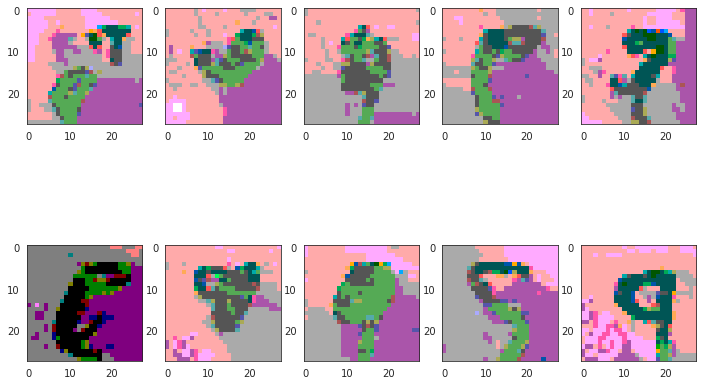

In [19]:
plt.rcParams['figure.figsize'] = 12, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        im = im_grid[i, :, :, :].reshape(28, 28, 3) / 255.
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        axis[(i >= 5) * 1, i % 5].imshow(im, cmap='viridis')
plt.show()

In [ ]:
print(sample.size())
out = sample.cpu().detach().numpy()
plt.rcParams['figure.figsize'] = 12, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        im = out[i, :, :, :].reshape(28, 28, 3) / 255.
        
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        axis[(i >= 5) * 1, i % 5].imshow(im, cmap='viridis')
plt.show()

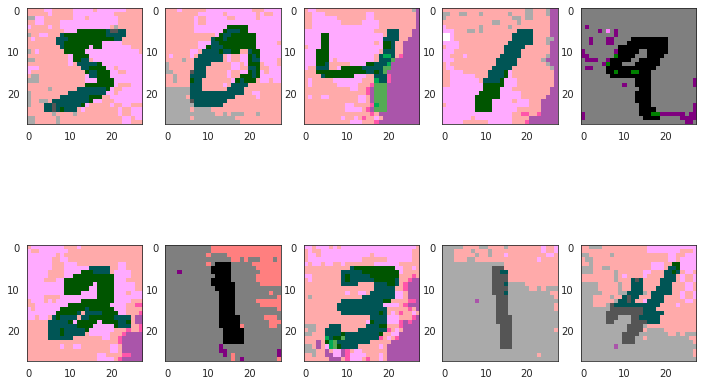

In [11]:
def load_data(path):
    with open(path, 'rb') as fp:
        data = pickle.load(fp)
    train_valid = data['train'].astype(np.float32)
    test = data['test'].astype(np.float32)
    return train_valid, test

train_valid, x_test = load_data('mnist-hw1.pkl')
x_train = train_valid[:int(len(train_valid)*0.8)]
plt.rcParams['figure.figsize'] = 12, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        im = x_train[i, :, :, :].reshape(28, 28, 3) / 255.
        
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        axis[(i >= 5) * 1, i % 5].imshow(im, cmap='viridis')
plt.show()